In [44]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pyfolio as pf
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA, plotting
import copy

In [45]:
data = yf.download(tickers="SPY QQQ CQQQ IEF TMF", period='10y')

[*********************100%***********************]  5 of 5 completed


In [46]:
df = data.Close.fillna(method='ffill')

In [47]:
weekly = df.resample('W-FRI').last().iloc[:-1]

In [48]:
weekly.pct_change().cov()*52

,CQQQ,IEF,QQQ,SPY,TMF
CQQQ,0.073456,-0.002328,0.030253,0.022916,-0.016538
IEF,-0.002328,0.003310,-0.001822,-0.002315,0.021309
QQQ,0.030253,-0.001822,0.031529,0.025144,-0.011282
SPY,0.022916,-0.002315,0.025144,0.024206,-0.014907
TMF,-0.016538,0.021309,-0.011282,-0.014907,0.160554


In [49]:
mu = expected_returns.mean_historical_return(df)
S = weekly.pct_change().cov()*52
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [50]:
cleaned_weights

OrderedDict([('CQQQ', 0.0),
             ('IEF', 0.0),
             ('QQQ', 0.99146),
             ('SPY', 0.0),
             ('TMF', 0.00854)])

In [51]:
mu = expected_returns.mean_historical_return(df)
S = weekly.pct_change().cov()*52
ef = EfficientFrontier(mu, S, weight_bounds=(0.05, 0.5))

In [52]:
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [53]:
cleaned_weights

OrderedDict([('CQQQ', 0.05),
             ('IEF', 0.05),
             ('QQQ', 0.5),
             ('SPY', 0.35),
             ('TMF', 0.05)])

In [54]:
selected = [k for k in cleaned_weights if cleaned_weights[k] > 0]
selected_weight = [cleaned_weights[k] for k in cleaned_weights if cleaned_weights[k] > 0]

In [55]:
cleaned_weights.items()

odict_items([('CQQQ', 0.05), ('IEF', 0.05), ('QQQ', 0.5), ('SPY', 0.35), ('TMF', 0.05)])

In [56]:
cleaned_weights.keys()

odict_keys(['CQQQ', 'IEF', 'QQQ', 'SPY', 'TMF'])

In [57]:
cleaned_weights.values()

odict_values([0.05, 0.05, 0.5, 0.35, 0.05])

In [58]:
selected

['CQQQ', 'IEF', 'QQQ', 'SPY', 'TMF']

In [59]:
selected_weight

[0.05, 0.05, 0.5, 0.35, 0.05]

In [60]:
for k in cleaned_weights.keys():
    if cleaned_weights[k] > 0:
        print(k)
    else:
        print('No')

CQQQ
IEF
QQQ
SPY
TMF


In [61]:
port = df[selected]
port_ret = port.pct_change()

In [62]:
# assume no fees
intial_amount = 1000000

In [63]:
port_ret

,CQQQ,IEF,QQQ,SPY,TMF
Date,,,,,
2012-05-07,NaN,NaN,NaN,NaN,NaN
2012-05-08,-0.016457,0.002266,-0.003706,-0.004012,0.017499
2012-05-09,-0.014091,0.000848,-0.003100,-0.005932,0.000445
2012-05-10,-0.003126,-0.001412,-0.002021,0.002063,-0.008447
2012-05-11,-0.000448,0.003299,-0.000156,-0.003014,0.024212
...,...,...,...,...,...
2022-05-02,0.006483,-0.008657,0.016696,0.006019,-0.052228
2022-05-03,0.012652,0.001177,0.001068,0.004584,0.019104
2022-05-04,0.008405,0.006468,0.033812,0.030453,0.015862


In [64]:
(port_ret+1).cumprod()

,CQQQ,IEF,QQQ,SPY,TMF
Date,,,,,
2012-05-07,NaN,NaN,NaN,NaN,NaN
2012-05-08,0.983543,1.002266,0.996294,0.995988,1.017499
2012-05-09,0.969684,1.003116,0.993206,0.990080,1.017951
2012-05-10,0.966652,1.001699,0.991198,0.992123,1.009353
2012-05-11,0.966219,1.005004,0.991044,0.989132,1.033791
...,...,...,...,...,...
2022-05-02,1.882633,0.962326,4.917851,3.023195,0.821240
2022-05-03,1.906453,0.963460,4.923101,3.037053,0.836929
2022-05-04,1.922477,0.969691,5.089561,3.129540,0.850204


In [65]:
port_value = (port_ret+1).cumprod()*selected_weight*intial_amount

In [66]:
port_value

,CQQQ,IEF,QQQ,SPY,TMF
Date,,,,,
2012-05-07,NaN,NaN,NaN,NaN,NaN
2012-05-08,49177.130650,50113.302736,4.981470e+05,3.485959e+05,50874.940426
2012-05-09,48484.190649,50155.789911,4.966028e+05,3.465281e+05,50897.573107
2012-05-10,48332.610540,50084.974351,4.955991e+05,3.472429e+05,50467.644243
2012-05-11,48310.955649,50250.211860,4.955219e+05,3.461962e+05,51689.544300
...,...,...,...,...,...
2022-05-02,94131.660748,48116.322654,2.458925e+06,1.058118e+06,41061.998699
2022-05-03,95322.650859,48172.975823,2.461550e+06,1.062969e+06,41846.431420
2022-05-04,96123.861187,48484.559247,2.544781e+06,1.095339e+06,42510.182405


In [67]:
port_value['total'] = port_value.sum(axis=1)
port_value

,CQQQ,IEF,QQQ,SPY,TMF,total
Date,,,,,,
2012-05-07,NaN,NaN,NaN,NaN,NaN,0.000000e+00
2012-05-08,49177.130650,50113.302736,4.981470e+05,3.485959e+05,50874.940426,9.969082e+05
2012-05-09,48484.190649,50155.789911,4.966028e+05,3.465281e+05,50897.573107,9.926685e+05
2012-05-10,48332.610540,50084.974351,4.955991e+05,3.472429e+05,50467.644243,9.917273e+05
2012-05-11,48310.955649,50250.211860,4.955219e+05,3.461962e+05,51689.544300,9.919688e+05
...,...,...,...,...,...,...
2022-05-02,94131.660748,48116.322654,2.458925e+06,1.058118e+06,41061.998699,3.700353e+06
2022-05-03,95322.650859,48172.975823,2.461550e+06,1.062969e+06,41846.431420,3.709861e+06
2022-05-04,96123.861187,48484.559247,2.544781e+06,1.095339e+06,42510.182405,3.827238e+06


In [68]:
port_value.iloc[0, -1] = intial_amount

In [69]:
port_value

,CQQQ,IEF,QQQ,SPY,TMF,total
Date,,,,,,
2012-05-07,NaN,NaN,NaN,NaN,NaN,1.000000e+06
2012-05-08,49177.130650,50113.302736,4.981470e+05,3.485959e+05,50874.940426,9.969082e+05
2012-05-09,48484.190649,50155.789911,4.966028e+05,3.465281e+05,50897.573107,9.926685e+05
2012-05-10,48332.610540,50084.974351,4.955991e+05,3.472429e+05,50467.644243,9.917273e+05
2012-05-11,48310.955649,50250.211860,4.955219e+05,3.461962e+05,51689.544300,9.919688e+05
...,...,...,...,...,...,...
2022-05-02,94131.660748,48116.322654,2.458925e+06,1.058118e+06,41061.998699,3.700353e+06
2022-05-03,95322.650859,48172.975823,2.461550e+06,1.062969e+06,41846.431420,3.709861e+06
2022-05-04,96123.861187,48484.559247,2.544781e+06,1.095339e+06,42510.182405,3.827238e+06


In [70]:
port_value['port_return'] = port_value.total.pct_change()

In [71]:
port_value.index = pd.to_datetime(port_value.index).tz_localize('UTC')

In [72]:
returns = port_value['port_return']

In [73]:
returns

Date
2012-05-07 00:00:00+00:00         NaN
2012-05-08 00:00:00+00:00   -0.003092
2012-05-09 00:00:00+00:00   -0.004253
2012-05-10 00:00:00+00:00   -0.000948
2012-05-11 00:00:00+00:00    0.000244
                               ...   
2022-05-02 00:00:00+00:00    0.012209
2022-05-03 00:00:00+00:00    0.002569
2022-05-04 00:00:00+00:00    0.031639
2022-05-05 00:00:00+00:00   -0.046108
2022-05-06 00:00:00+00:00   -0.009195
Name: port_return, Length: 2518, dtype: float64

In [74]:
positions = port_value.iloc[:,:-2]

In [75]:
positions.head()

,CQQQ,IEF,QQQ,SPY,TMF
Date,,,,,
2012-05-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2012-05-08 00:00:00+00:00,49177.130650,50113.302736,498146.961973,348595.907662,50874.940426
2012-05-09 00:00:00+00:00,48484.190649,50155.789911,496602.822522,346528.080289,50897.573107
2012-05-10 00:00:00+00:00,48332.610540,50084.974351,495599.137770,347242.883851,50467.644243
2012-05-11 00:00:00+00:00,48310.955649,50250.211860,495521.913126,346196.193294,51689.544300


In [76]:
positions['cash'] = 0
positions.iloc[0,-1] = intial_amount
positions

C:\Users\gunsr\AppData\Local\Temp\ipykernel_51616\766916208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions['cash'] = 0
c:\Users\gunsr\anaconda3\envs\investing\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CQQQ,IEF,QQQ,SPY,TMF,cash
Date,,,,,,
2012-05-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,1000000
2012-05-08 00:00:00+00:00,49177.130650,50113.302736,4.981470e+05,3.485959e+05,50874.940426,0
2012-05-09 00:00:00+00:00,48484.190649,50155.789911,4.966028e+05,3.465281e+05,50897.573107,0
2012-05-10 00:00:00+00:00,48332.610540,50084.974351,4.955991e+05,3.472429e+05,50467.644243,0
2012-05-11 00:00:00+00:00,48310.955649,50250.211860,4.955219e+05,3.461962e+05,51689.544300,0
...,...,...,...,...,...,...
2022-05-02 00:00:00+00:00,94131.660748,48116.322654,2.458925e+06,1.058118e+06,41061.998699,0
2022-05-03 00:00:00+00:00,95322.650859,48172.975823,2.461550e+06,1.062969e+06,41846.431420,0
2022-05-04 00:00:00+00:00,96123.861187,48484.559247,2.544781e+06,1.095339e+06,42510.182405,0


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.82,2020-02-19,2020-03-23,2020-06-08,79
1,21.49,2021-12-27,2022-05-06,NaT,NaN
2,20.99,2018-08-29,2018-12-24,2019-04-17,166
3,13.25,2015-12-01,2016-02-11,2016-07-11,160
4,12.47,2015-04-24,2015-08-25,2015-11-03,138


c:\Users\gunsr\anaconda3\envs\investing\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


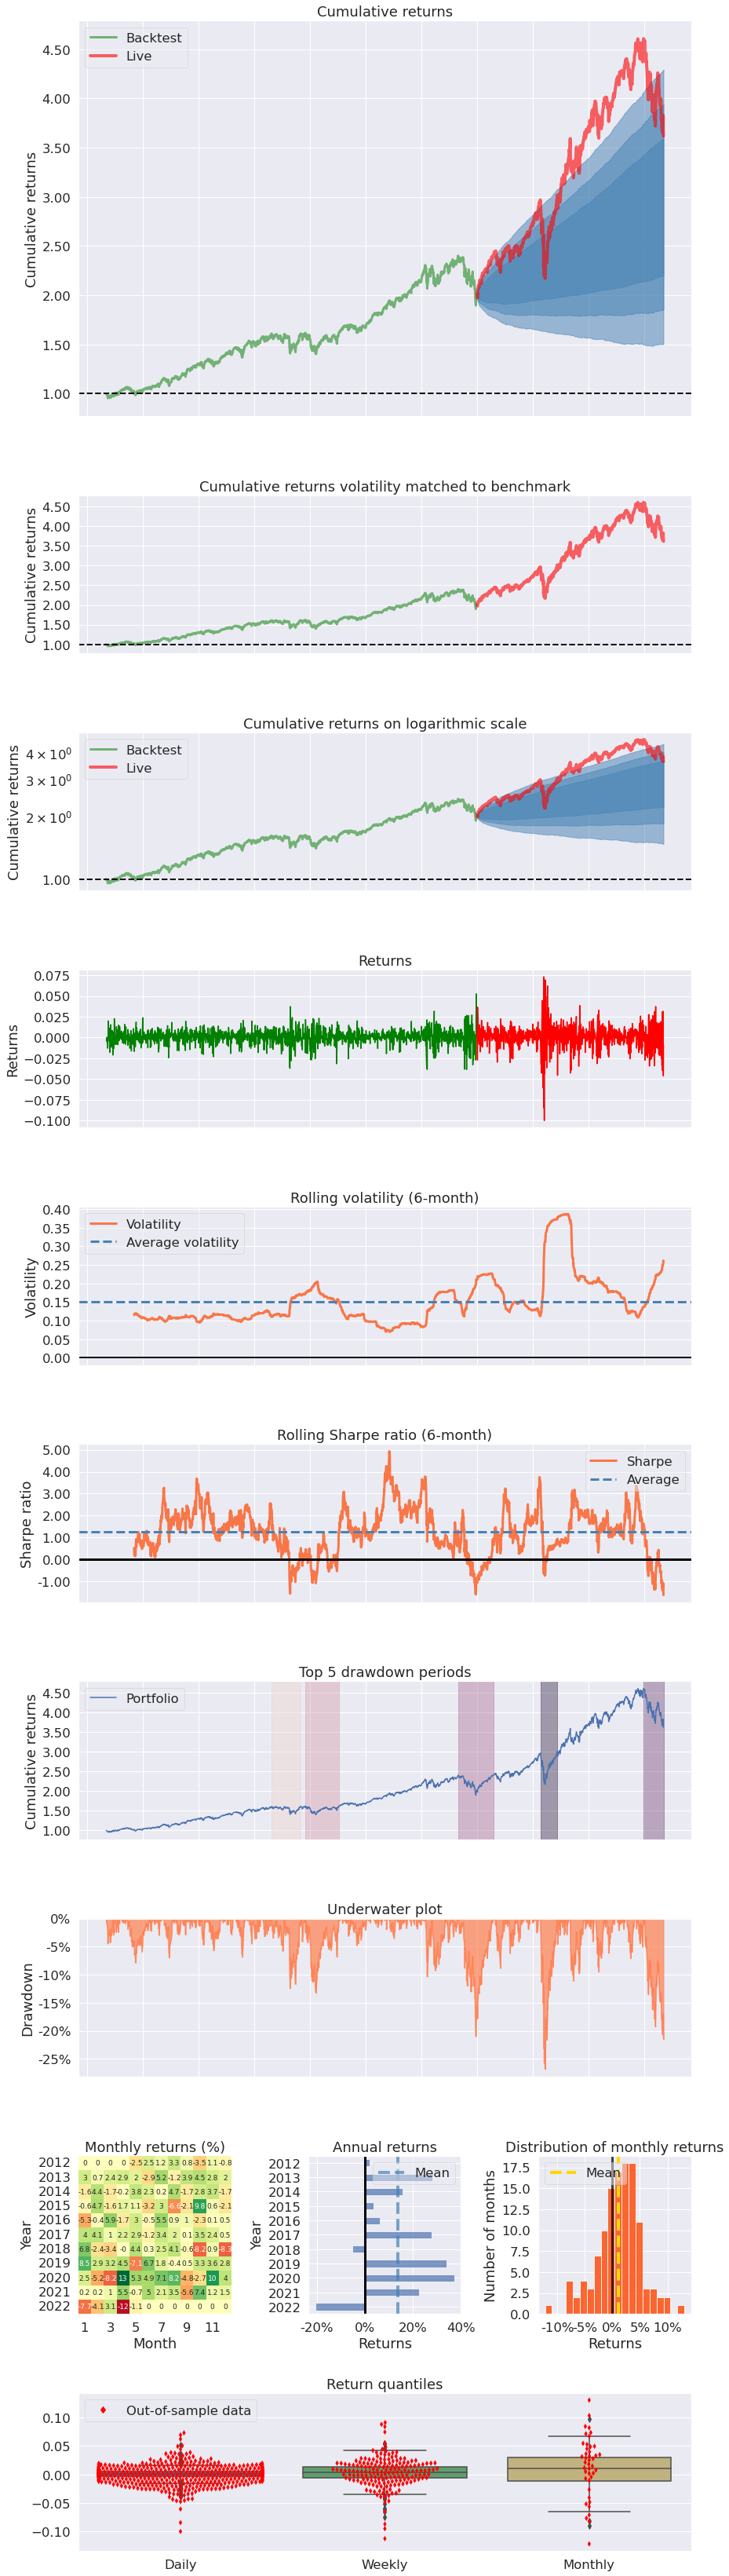

In [77]:
pf.create_returns_tear_sheet(returns, live_start_date='2018-12-31', positions=positions)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.82,2020-02-19,2020-03-23,2020-06-08,79
1,21.49,2021-12-27,2022-05-06,NaT,NaN
2,20.99,2018-08-29,2018-12-24,2019-04-17,166
3,13.25,2015-12-01,2016-02-11,2016-07-11,160
4,12.47,2015-04-24,2015-08-25,2015-11-03,138


c:\Users\gunsr\anaconda3\envs\investing\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\gunsr\anaconda3\envs\investing\lib\site-packages\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
EZB IR Event,-0.09%,-1.29%,1.27%
Apr14,0.01%,-2.32%,1.38%
Oct14,0.13%,-1.75%,2.06%
Fall2015,-0.24%,-3.71%,3.73%
Recovery,0.01%,-2.12%,2.28%
New Normal,0.06%,-10.00%,7.32%


Top 10 long positions of all time,max
QQQ,67.74%
SPY,37.50%
TMF,7.06%
CQQQ,6.82%
IEF,5.39%


Top 10 short positions of all time,max


Top 10 positions of all time,max
QQQ,67.74%
SPY,37.50%
TMF,7.06%
CQQQ,6.82%
IEF,5.39%


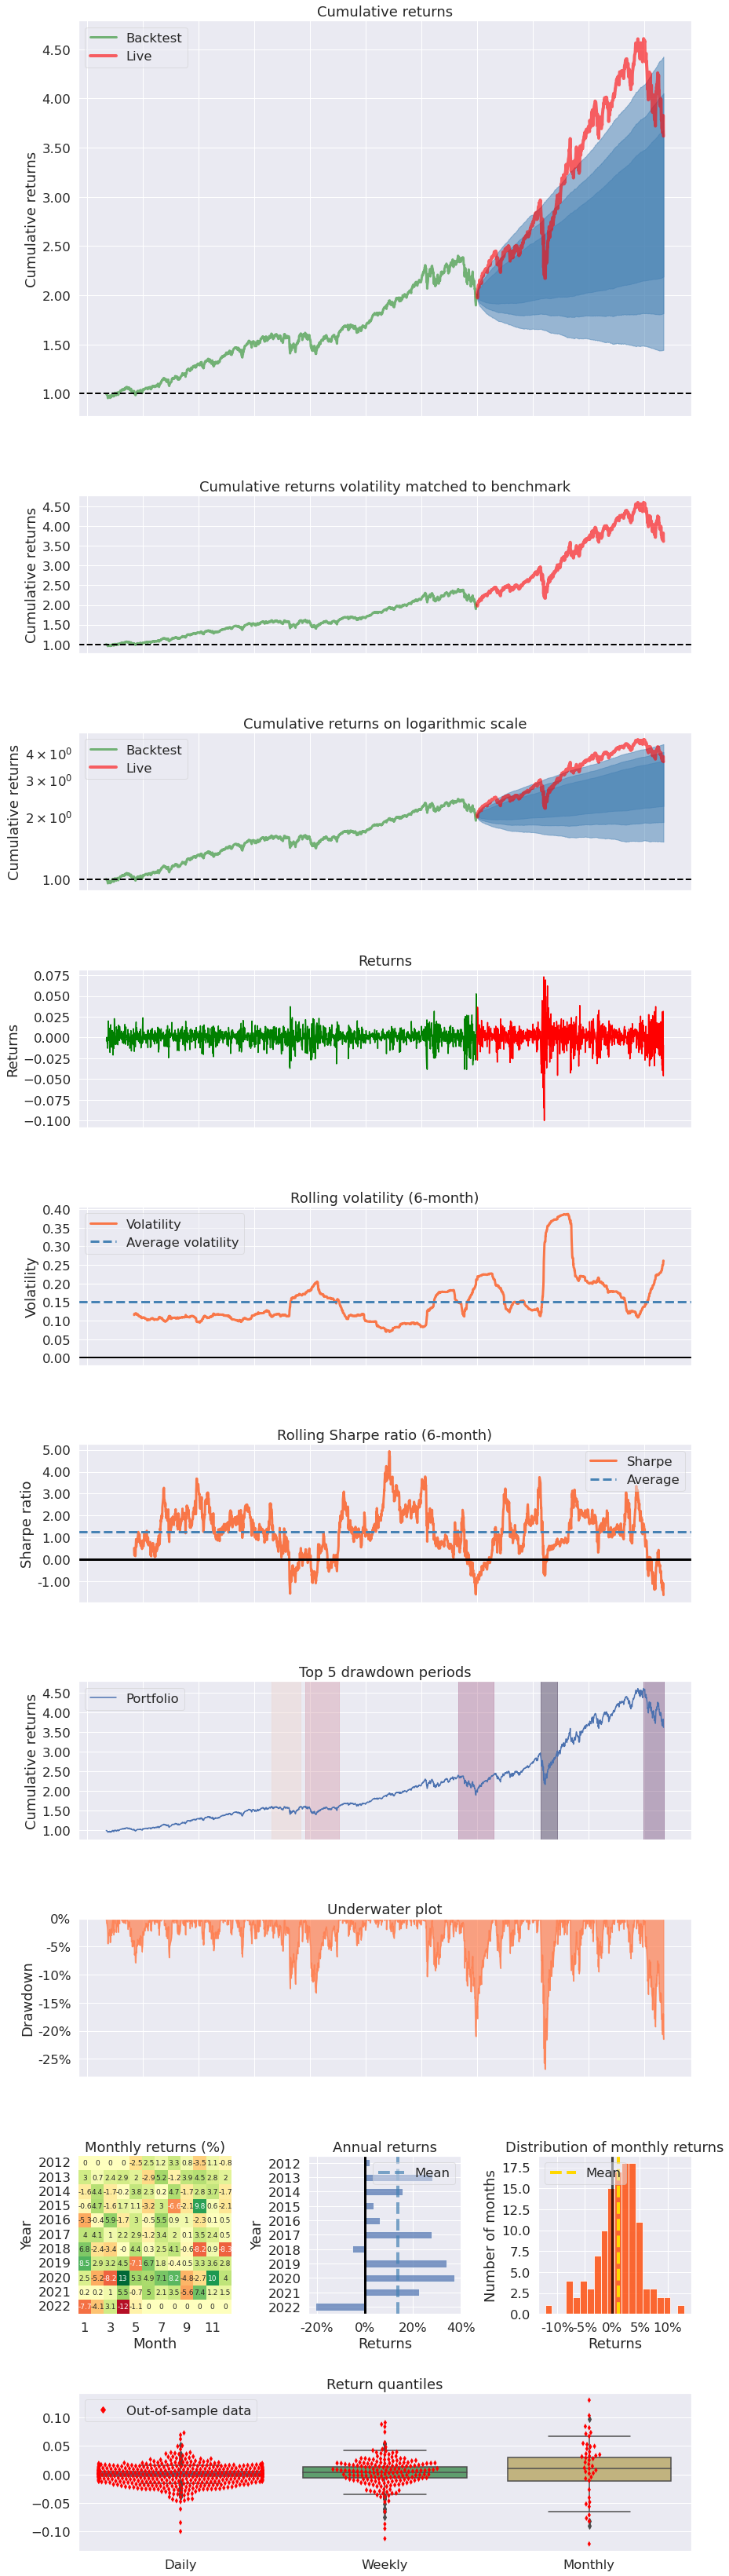

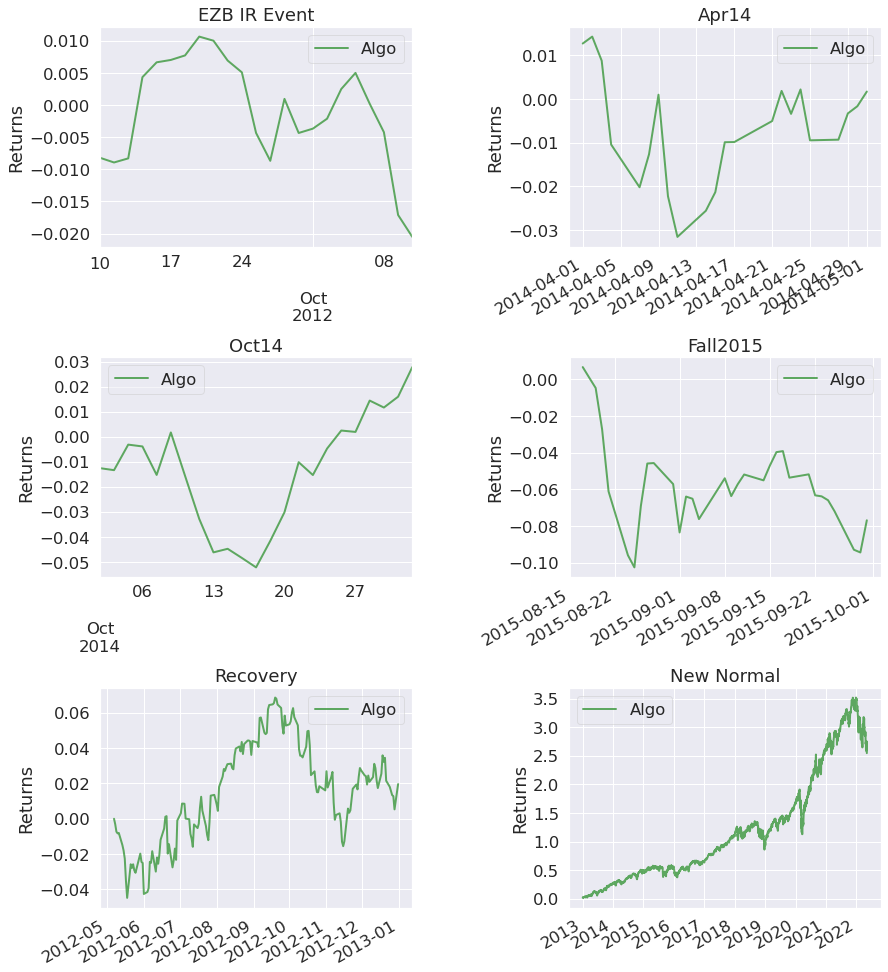

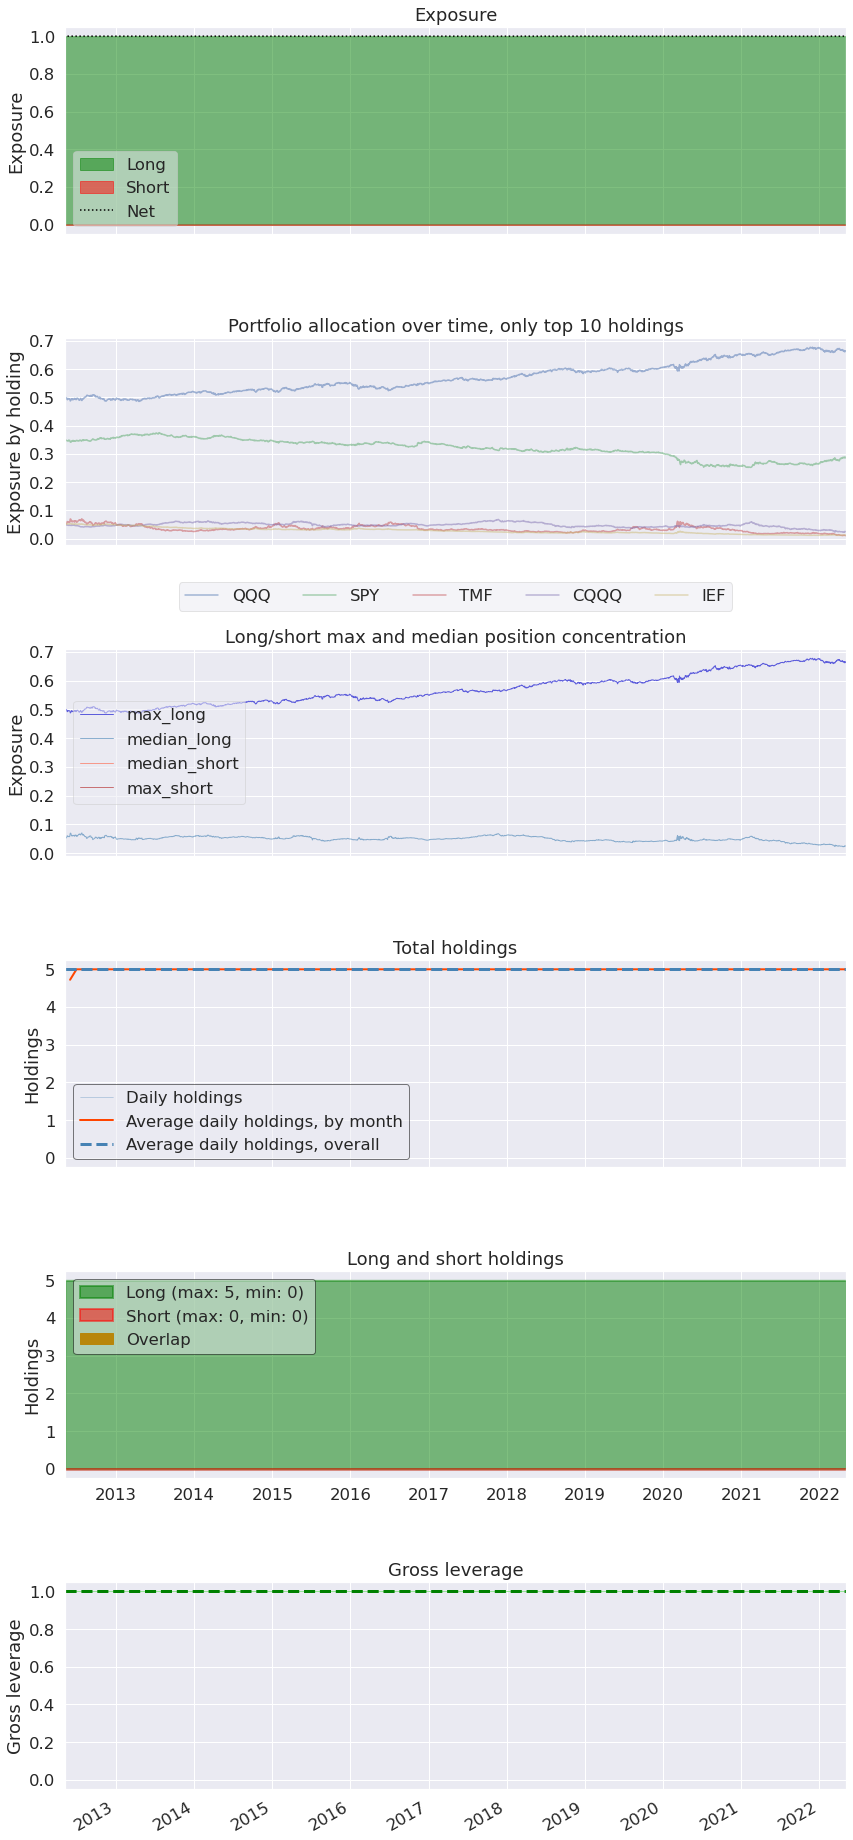

In [78]:
pf.create_full_tear_sheet(returns, live_start_date='2018-12-31', positions=positions)

Expected annual return: 10.9%
Annual volatility: 12.4%
Sharpe Ratio: 0.71


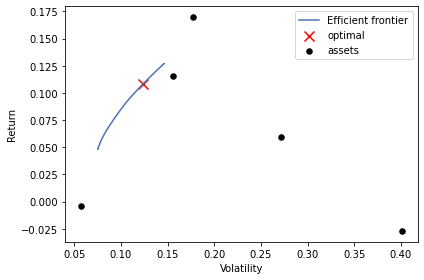

In [79]:
cla = CLA(mu, S, weight_bounds=(0.05, 0.5))
cla.max_sharpe()
cla.portfolio_performance(verbose=True)
ax = plotting.plot_efficient_frontier(cla, showfig=False, show_assets=True)

Expected annual return: 10.9%
Annual volatility: 12.4%
Sharpe Ratio: 0.71


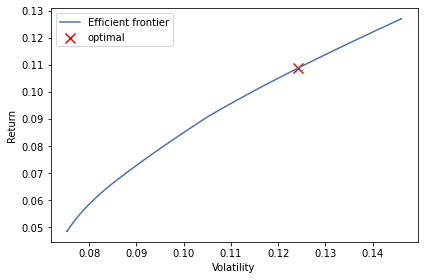

In [80]:
cla = CLA(mu, S, weight_bounds=(0.05, 0.5))
cla.max_sharpe()
cla.portfolio_performance(verbose=True)
ax = plotting.plot_efficient_frontier(cla, showfig=False, show_assets=False)

Expected annual return: 15.0%
Annual volatility: 15.7%
Sharpe Ratio: 0.83


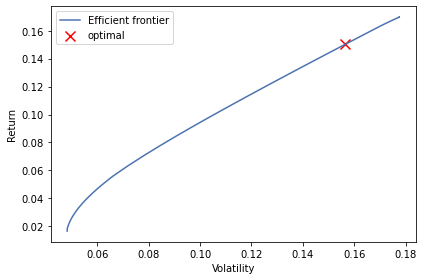

In [81]:
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)
ax = plotting.plot_efficient_frontier(cla, showfig=False, show_assets=False)

Expected annual return: 1.6%
Annual volatility: 4.8%
Sharpe Ratio: -0.07


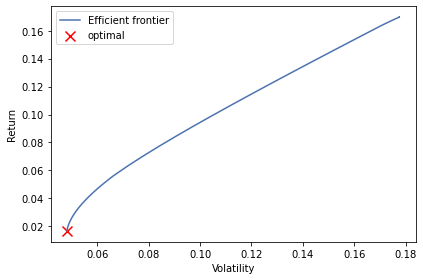

In [82]:
cla = CLA(mu, S)
cla.min_volatility()
cla.portfolio_performance(verbose=True)
ax = plotting.plot_efficient_frontier(cla, showfig=False, show_assets=False)

In [83]:
help(ef)

Help on EfficientFrontier in module pypfopt.efficient_frontier.efficient_frontier object:

class EfficientFrontier(pypfopt.base_optimizer.BaseConvexOptimizer)
 |  EfficientFrontier(expected_returns, cov_matrix, weight_bounds=(0, 1), solver=None, verbose=False, solver_options=None)
 |  
 |  An EfficientFrontier object (inheriting from BaseConvexOptimizer) contains multiple
 |  optimization methods that can be called (corresponding to different objective
 |  functions) with various parameters. Note: a new EfficientFrontier object should
 |  be instantiated if you want to make any change to objectives/constraints/bounds/parameters.
 |  
 |  Instance variables:
 |  
 |  - Inputs:
 |  
 |      - ``n_assets`` - int
 |      - ``tickers`` - str list
 |      - ``bounds`` - float tuple OR (float tuple) list
 |      - ``cov_matrix`` - np.ndarray
 |      - ``expected_returns`` - np.ndarray
 |      - ``solver`` - str
 |      - ``solver_options`` - {str: str} dict
 |  
 |  - Output: ``weights`` - np